# Covid-19 New Cases Forecasting using Support Vector Machine Regression

We examine the performance of Support Vector Regression (SVR) to predict the number of new  Covid-19 cases in each day. The dataset used is from Our World in Data, available from [https://ourworldindata.org/coronavirus-source-data](https://ourworldindata.org/coronavirus-source-data), donwloaded on 16-12-2020. See more info about the dataset in the [public Github repository](https://github.com/owid/covid-19-data/tree/master/public/data). [The dataseet codebook](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

In [61]:
import os 
import datetime
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

world_dataset = pd.read_csv('owid-covid-data.csv')

The model will use the `new_cases` column as a target. For the inputs, we use `date`, `new_cases_smoothed` and we add features indicating the day of the week via one-hot encoding. Where available, we use the `stringency_index` that measures the strength of tthe measures put in place by the country government (lockdown, business closures, school closures, etc). 

In [2]:
world_all = world_dataset.loc[(world_dataset['location'] == 'World')]
italy_all = world_dataset.loc[(world_dataset['location'] == 'Italy')]
ireland_all = world_dataset.loc[(world_dataset['location'] == 'Ireland')]
brazil_all = world_dataset.loc[(world_dataset['location'] == 'Brazil')]

## Brazil new cases prediction

In [3]:
brazil = brazil_all.filter(items=['date', 'new_cases', 'new_cases_smoothed', 'stringency_index'])
brazil = brazil.fillna(0)
brazil.reset_index(drop=True, inplace=True)
#brazil_y = brazil.filter(items=['date', 'new_cases'], axis=1)
#brazil_data = brazil.drop(['new_cases'], axis=1)
brazil

,date,new_cases,new_cases_smoothed,stringency_index
0,2020-02-26,0.0,0.000,5.56
1,2020-02-27,0.0,0.000,5.56
2,2020-02-28,0.0,0.000,5.56
3,2020-02-29,1.0,0.000,5.56
4,2020-03-01,0.0,0.000,5.56
...,...,...,...,...
289,2020-12-11,54428.0,43179.857,0.00
290,2020-12-12,43900.0,43278.571,0.00
291,2020-12-13,21825.0,42630.286,0.00
292,2020-12-14,25193.0,43319.143,0.00


In [4]:
# get weekday for one-hot encoding
def get_weekday(date_col):
    datetime_col = [datetime.date.fromisoformat(x) for x in date_col]
    weekday_col = [x.weekday() for x in datetime_col]
    return weekday_col

weekdays = get_weekday(brazil['date'].values)
weekdays_pd = pd.DataFrame(weekdays, columns=['weekday'])
weekdays_ohe = pd.get_dummies(weekdays_pd, columns=['weekday'])
weekdays_ohe = weekdays_ohe.rename(columns = {'weekday_0': 'Monday', 'weekday_1': 'Tuesday', 'weekday_2': 'Wednesday', 'weekday_3': 'Thursday', 'weekday_4': 'Friday','weekday_5': 'Saturday','weekday_6': 'Sunday'})
weekdays_ohe

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
289,0,0,0,0,1,0,0
290,0,0,0,0,0,1,0
291,0,0,0,0,0,0,1
292,1,0,0,0,0,0,0


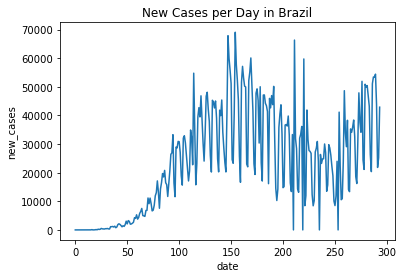

In [5]:
# final values for dataset (input X and target y)
brazil = pd.concat([brazil, weekdays_ohe], axis=1)
brazil['day'] = brazil.index
brazil.set_index('date', drop=True, inplace=True)
plt.plot(brazil['day'], brazil['new_cases'])
plt.xlabel('date')
plt.ylabel('new_cases')
plt.title("New Cases per Day in Brazil")
plt.show()

The data needs to be normalised before appying the SVR model, according to [scikit-learn user guide on SVR](https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use). 

    Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. 

We do this via the `StandardScaler()` and `MinMaxScaler()` methods. 
- `StandardScaler()`: transforms features into a normal distribution with mean zero and standard deviation of one. This will be applied for columns that are cardinal/float values (`new_cases` and `new_cases_smoothed`).
- `MinMaxScaler()`: transforms features by scaling to a range [0,1]. This will be applied to the other columns that are either binary or ordinal.

In [29]:
# normalise data

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

col_transf = ColumnTransformer(
    [ ('normal1', StandardScaler(), ['new_cases']),
     ('normal2', StandardScaler(), ['new_cases_smoothed']) ], 
    remainder=MinMaxScaler() )
brazil_scaled = col_transf.fit_transform(brazil)
brazil_scaled = pd.DataFrame(brazil_scaled, index=brazil.index, columns=brazil.columns)
brazil_scaled

,new_cases,new_cases_smoothed,stringency_index,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,day
date,,,,,,,,,,,
2020-02-26,-1.324529,-1.554557,0.068625,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
2020-02-27,-1.324529,-1.554557,0.068625,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.003413
2020-02-28,-1.324529,-1.554557,0.068625,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.006826
2020-02-29,-1.324473,-1.554557,0.068625,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.010239
2020-03-01,-1.324529,-1.554557,0.068625,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.013652
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-11,1.716331,1.321909,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.986348
2020-12-12,1.128138,1.328485,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.989761
2020-12-13,-0.105179,1.285299,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.993174


## The model

Now that the data is preprocessed, we separate the dataframe into X (the input vector for the SVR model) and y (the target vector).

In [7]:
from sklearn.model_selection import train_test_split

X = brazil_scaled.drop(['new_cases'], axis=1)
y = brazil_scaled['new_cases']

In [8]:
from sklearn import svm

The Support Vector Machine can use different types of *kernel* functions (linear, polynomial, radial basis function, sigmoid or user-defined). To see an explanation on those, refer to [SVM kernel functions](https://scikit-learn.org/stable/modules/svm.html#kernel-functions). The scikit-learn user guide also provides a [comparative example](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html).

The `SVR()` class is used to build the model; [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html).

In [9]:
def get_fitted_model(X, y, kernel):
    model = svm.SVR(kernel=kernel)
    model.fit(X,y)
    return model

In [10]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
models = [get_fitted_model(X, y, k) for k in kernels]
models_dict = zip(kernels, models)
print("Linear SVR - Coeff of determination on training dataset (R^2): ", models[0].score(X, y))
print("Poly SVR - Coeff of determination on training dataset (R^2): ", models[1].score(X, y))
print("RBF SVR - Coeff of determination on training dataset (R^2): ", models[2].score(X, y))
print("Sigmoid SVR - Coeff of determination on training dataset (R^2): ", models[3].score(X, y))

Linear SVR - Coeff of determination on training dataset (R^2):  0.8170811856814844
Poly SVR - Coeff of determination on training dataset (R^2):  0.8867312690170843
RBF SVR - Coeff of determination on training dataset (R^2):  0.8884946892130177
Sigmoid SVR - Coeff of determination on training dataset (R^2):  -28.33479393887087


In [11]:
def plot_model(X, y, model):
    y_pred = model.predict(X)
    sv_ind = model.support_
    plt.plot(X['day'], y, label='data', color='blue')
    plt.plot(X['day'], y_pred, label='predicted', color='red')
    plt.scatter((X['day'].to_numpy())[sv_ind], y.to_numpy()[sv_ind], label='SV', color='green')
    plt.xlabel('date')
    plt.ylabel('new_cases normalised')
    plt.legend()
    plt.title("model: " + model.get_params()['kernel'])
    plt.show()

In [12]:
models[0].get_params()['kernel']

'linear'

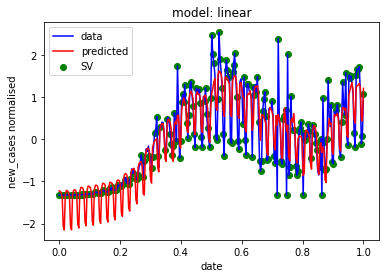

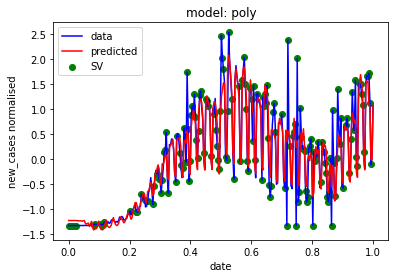

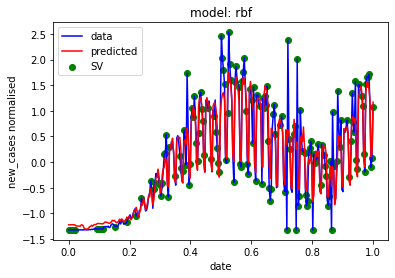

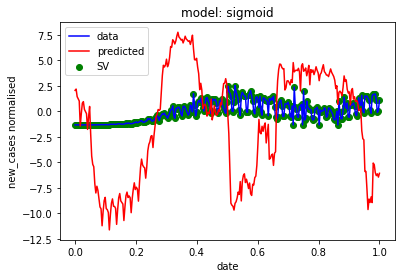

In [13]:
for m in models:
    plot_model(X, y, m)

In [14]:
y_pred = models[2].predict(X)
sv_ind = models[2].support_

## Performance criteria
*Mean-Square Error* (RMSE), *Mean Absolute Error* (MAE) and *Coefficient of Determination* (R^2).

In [15]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

MAE = mean_absolute_error(y, y_pred)
print("Mean-absolute-error (MAE): ", MAE)

MSE = mean_squared_error(y, y_pred)
print("Mean-squared-error (MSE): ", MSE)
print("Root-mean-squared-error (RMSE): ", np.sqrt(MSE))

R2 = r2_score(y, y_pred)
print("R^2 score (R2): ", R2)

Mean-absolute-error (MAE):  0.19224689978364162
Mean-squared-error (MSE):  0.1115053107869823
Root-mean-squared-error (RMSE):  0.33392410932273564
R^2 score (R2):  0.8884946892130177


## Trying with a pipeline


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

X_p = brazil.drop(['new_cases'], axis=1)
y_p = brazil['new_cases']

coltransf = ColumnTransformer(
    [ ('normal', StandardScaler(), ['new_cases_smoothed']) ], 
    remainder=MinMaxScaler() )


y_p_norm = pd.DataFrame(StandardScaler().fit_transform(y_p.values.reshape(-1,1)), 
                        index=y_p.index, columns=['new_cases']).values.ravel()

pipe = Pipeline([
    ('scaler', coltransf),
    ('svr', svm.SVR(kernel='rbf', C=1))
])

cv = KFold(n_splits=5, shuffle=True)
pipe.fit(X_p,y_p_norm)
np.mean(cross_val_score(pipe, X_p, y_p_norm, cv=cv, scoring='r2'))

0.8703139922180545

In [17]:
y_p_pred = pipe.predict(X_p)
r2_score(y_p_norm, y_p_pred)

0.8884946892130177

## GridSearchCV - finding the best parameters

When building an SVR model with a Radial Basis Function (RBF) kernel, the hyperparameters C and gamma need to be optimised (hyperparameter tunning).

The `gamma` parameter defines the weight of influence of a single training sample. A high `gamma` restricts the sample to a "close" influence, whereas a low `gamma` value extends the influence of the example to "far".

The `C` parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower `C` will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words `C` behaves as a regularization parameter in the SVM.

For a more comprehensive explanation of the RBF kernel parameters, see [link](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).

We will now do a Grid Search Cross-Validation ([example][gridsearchcv]) to verify which `C` and `gamma` values are the best for this regression task. The default values for `C` is 1.0 and `gamma` is `scale`.

[gridsearchcv]: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

See more about Cross-Validation on the [scikit-learn page on Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

See also [Model Selection](https://sklearn.org/tutorial/statistical_inference/model_selection.html).

In [20]:
parameters = {
    "kernel": ["rbf"],
    "C": [1,10,100,1000],
    "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 'scale'],
    "epsilon": [1e-3, 1e-2, 1e-1, 1.0, 10]
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(svm.SVR(), parameters, cv=cv, scoring='r2')
grid.fit(X, y)
print("The best parameters are %s with a score of %0.3f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 100, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'} with a score of 0.878


## World new cases

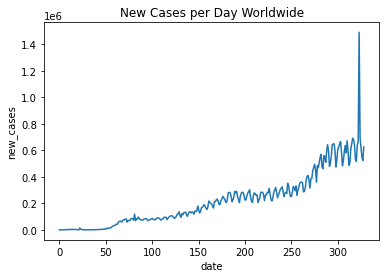

In [59]:
# get dataframe with relevant features
world = world_all.filter(items=['date', 'new_cases', 'new_cases_smoothed'])
# preprocessing
world = world.fillna(0)
world.reset_index(drop=True, inplace=True)
# get weekdays
weekdays = get_weekday(world['date'].values)
world['weekday'] = weekdays
# substitute index as the date and add a column as the ordinal day since the first day
world['day'] = world.index
world.set_index('date', drop=True, inplace=True)

#plot the new cases per day
plt.plot(world['day'], world['new_cases'])
plt.xlabel('date')
plt.ylabel('new_cases')
plt.title("New Cases per Day Worldwide")
plt.show()

In [77]:
# get input features and target (new_cases)
X_w = world.drop(['new_cases'], axis=1)
y_w = world['new_cases']

##### building pipeline for regression task #####
# transformer/scaler for features
coltransfw = ColumnTransformer(
    [ 
        ('normal', StandardScaler(), ['new_cases_smoothed']),
        ('one-hot-enc', OneHotEncoder(), ['weekday'])
    ], 
    remainder=MinMaxScaler() )
y_w_norm = pd.DataFrame(StandardScaler().fit_transform(y_w.values.reshape(-1,1)), 
                        index=y_w.index, columns=['new_cases']).values.ravel()
# pipeline
pipe_w = Pipeline([
     ('scaler', coltransfw),
     ('svr', svm.SVR())
])
cv_w = KFold(n_splits=5, shuffle=True)

pipe_w.fit(X_w,y_w_norm)
print("Mean cross-validation score (R2):", np.mean(cross_val_score(pipe_w, X_w, y_w_norm, cv=cv_w, scoring='r2')))
y_pred_w = pipe_w.predict(X_w)
MAE = mean_absolute_error(y_w_norm, y_pred_w)
print("Mean-absolute-error (MAE): ", MAE)
MSE = mean_squared_error(y_w_norm, y_pred_w)
print("Mean-squared-error (MSE): ", MSE)
print("Root-mean-squared-error (RMSE): ", np.sqrt(MSE))

Mean cross-validation score (R2): 0.9575864731903773
Mean-absolute-error (MAE):  0.06966297612769158
Mean-squared-error (MSE):  0.05230386040689757
Root-mean-squared-error (RMSE):  0.22870037255522252


In [82]:
# find the best parameters for the rbf SVM kernel using GridSearchCV
parameters_w = {
    "svr__kernel": ["rbf"],
    "svr__C": [1,10,100,1000],
    "svr__gamma": [1e-3, 1e-2, 1e-1, 1.0, 'scale'],
    "svr__epsilon": [1e-3, 1e-2, 1e-1, 1.0, 10]
}

grid_w = GridSearchCV(pipe_w, parameters_w, cv=cv_w, scoring='r2')
grid_w.fit(X_w, y_w_norm)
print("The best parameters are %s with a score of %0.3f"
       % (grid_w.best_params_, grid_w.best_score_))

The best parameters are {'svr__C': 1000, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'} with a score of 0.986


In [86]:
pipe_w.set_params(svr__kernel='rbf', svr__C=1000, svr__gamma='scale', svr__epsilon=0.1)
pipe_w.fit(X_w, y_w_norm)
print("Mean cross-validation score (R2):", np.mean(cross_val_score(pipe_w, X_w, y_w_norm, cv=cv_w, scoring='r2')))
y_pred_w = pipe_w.predict(X_w)
MAE = mean_absolute_error(y_w_norm, y_pred_w)
print("Mean-absolute-error (MAE): ", MAE)
MSE = mean_squared_error(y_w_norm, y_pred_w)
print("Mean-squared-error (MSE): ", MSE)
print("Root-mean-squared-error (RMSE): ", np.sqrt(MSE))

Mean cross-validation score (R2): 0.9525012146907859
Mean-absolute-error (MAE):  0.057353407920442134
Mean-squared-error (MSE):  0.004538963949004851
Root-mean-squared-error (RMSE):  0.06737183349891


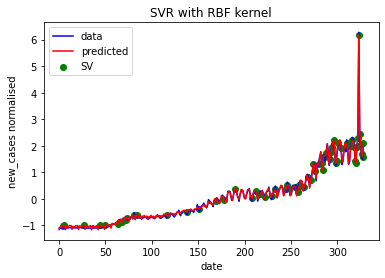

In [87]:
sv_ind_w = pipe_w.get_params()['svr'].support_
plt.plot(X_w['day'], y_w_norm, label='data', color='blue')
plt.plot(X_w['day'], y_pred_w, label='predicted', color='red')
plt.scatter((X_w['day'].to_numpy())[sv_ind_w], y_pred_w[sv_ind_w], label='SV', color='green')
plt.xlabel('date')
plt.ylabel('new_cases normalised')
plt.legend()
plt.title("SVR with RBF kernel")
plt.show()

There is an outlier in the `new_cases` column. We will now try to remove it and see if it improves the results.

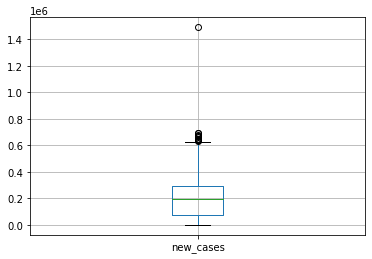

In [60]:
world.boxplot(column='new_cases')

In [65]:
z = np.abs(stats.zscore(world['new_cases']))
print(np.where(z>3))

(array([323], dtype=int64),)


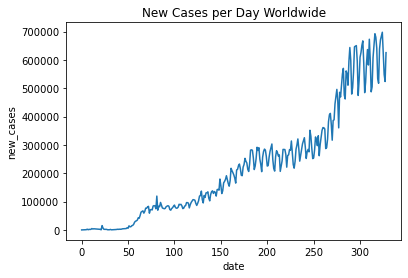

In [71]:
# remove outlier
worldr = world.loc[z<3]
plt.plot(worldr['day'], worldr['new_cases'])
plt.xlabel('date')
plt.ylabel('new_cases')
plt.title("New Cases per Day Worldwide")
plt.show()

In [88]:
# with outlier removed
# get input features and target (new_cases)
Xr_w = worldr.drop(['new_cases'], axis=1)
yr_w = worldr['new_cases']

##### building pipeline for regression task #####
# transformer/scaler for features
coltransfwr = ColumnTransformer(
    [ 
        ('normal', StandardScaler(), ['new_cases_smoothed']),
        ('one-hot-enc', OneHotEncoder(), ['weekday'])
    ], 
    remainder=MinMaxScaler() )
yr_w_norm = pd.DataFrame(StandardScaler().fit_transform(yr_w.values.reshape(-1,1)), 
                        index=yr_w.index, columns=['new_cases']).values.ravel()
# pipeline
piper_w = Pipeline([
     ('scaler', coltransfwr),
     ('svr', svm.SVR())
])
cvr_w = KFold(n_splits=5, shuffle=True)

piper_w.fit(Xr_w,yr_w_norm)
print("Mean cross-validation score (R2):", np.mean(cross_val_score(piper_w, Xr_w, yr_w_norm, cv=cvr_w, scoring='r2')))
yr_pred_w = pipe_w.predict(Xr_w)
MAE = mean_absolute_error(yr_w_norm, yr_pred_w)
print("Mean-absolute-error (MAE): ", MAE)
MSE = mean_squared_error(yr_w_norm, yr_pred_w)
print("Mean-squared-error (MSE): ", MSE)
print("Root-mean-squared-error (RMSE): ", np.sqrt(MSE))

Mean cross-validation score (R2): 0.9918385037450121
Mean-absolute-error (MAE):  0.07835849128462978
Mean-squared-error (MSE):  0.009507973090658576
Root-mean-squared-error (RMSE):  0.09750883596197103


In [89]:
# find the best parameters for the rbf SVM kernel using GridSearchCV
parameters_w = {
    "svr__kernel": ["rbf"],
    "svr__C": [1,10,100,1000],
    "svr__gamma": [1e-3, 1e-2, 1e-1, 1.0, 'scale'],
    "svr__epsilon": [1e-3, 1e-2, 1e-1, 1.0, 10]
}

gridr_w = GridSearchCV(piper_w, parameters_w, cv=cvr_w, scoring='r2')
gridr_w.fit(Xr_w, yr_w_norm)
print("The best parameters are %s with a score of %0.3f"
       % (gridr_w.best_params_, gridr_w.best_score_))

The best parameters are {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'} with a score of 0.994


In [90]:
piper_w.set_params(svr__kernel='rbf', svr__C=10, svr__gamma='scale', svr__epsilon=0.01)
piper_w.fit(Xr_w, yr_w_norm)
print("Mean cross-validation score (R2):", np.mean(cross_val_score(piper_w, Xr_w, yr_w_norm, cv=cvr_w, scoring='r2')))
yr_pred_w = piper_w.predict(Xr_w)
MAE = mean_absolute_error(yr_w_norm, yr_pred_w)
print("Mean-absolute-error (MAE): ", MAE)
MSE = mean_squared_error(yr_w_norm, yr_pred_w)
print("Mean-squared-error (MSE): ", MSE)
print("Root-mean-squared-error (RMSE): ", np.sqrt(MSE))

Mean cross-validation score (R2): 0.993347326805598
Mean-absolute-error (MAE):  0.03630323659336303
Mean-squared-error (MSE):  0.0034914944451249473
Root-mean-squared-error (RMSE):  0.05908886904591208


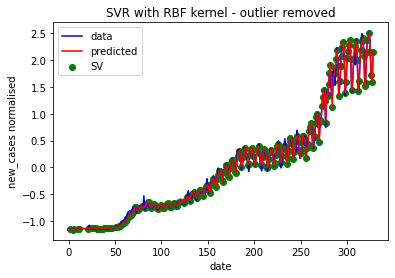

In [91]:
sv_ind_wr = piper_w.get_params()['svr'].support_
plt.plot(Xr_w['day'], yr_w_norm, label='data', color='blue')
plt.plot(Xr_w['day'], yr_pred_w, label='predicted', color='red')
plt.scatter((Xr_w['day'].to_numpy())[sv_ind_wr], yr_pred_w[sv_ind_wr], label='SV', color='green')
plt.xlabel('date')
plt.ylabel('new_cases normalised')
plt.legend()
plt.title("SVR with RBF kernel - outlier removed")
plt.show()